# Embedding Self-Organizing Maps in Neural Networks
**CS230 Project Milestone, Stephen Barnes / stbarnes / stbarnes@stanford.edu**

### Contents of this Notebook
1. Background
    1. Explanation of what self-organizing maps are.
    2. Aims of the project (trying to embed SOMs in neural nets).
    3. Explanation of how feedforward and backpropagation could work in a neural net with embedded SOMs.
    4. Review of prior work and variations.
2. Code
    1. Defining an SOM class, with initially random graph locations.
    2. Demonstrating that the SOM can successfully straighten itself out to cover a Gaussian dataset.
    3. Constructing datasets of spiralling points, and showing that the SOM can fit these fairly well
    4. Extending the SOM class to one that allows backpropagation, using the continuous output function defined below.
    5. Defining a class that can be used to conveniently construct models with both NNs and SOMs.
    6. Constructing a toy classification problem with spirally-distributed points.
    7. Evaluating the performance of a simple ordinary neural network (NN→NN) on this problem.
    8. Evaluating the performance of a simple SOM→NN model on this problem.
    9. Evaluating the performance of an NN→SOM→NN model on this problem.
3. Conclusions
    1. A list of challenges or problems reducing the usefulness of SOMs, and possible solutions to them.
    2. Suggestions for further research directions.


### What are self-organizing maps?                                                            
 
Self-organizing maps, also called Kohonen networks, were invented in the 1980s. As with early neural networks, they aimed to mimic the animal nervous system by implementing early models of associative memory and adaptive learning. While they enjoyed some initial success in pattern recognition, they are not very widely used today and are considered more as an historical curiosity than a viable machine learning technique.
 
An SOM learns an embedding of a graph in an input space that reflects the distribution of datapoints in that input space. For instance, given as datapoints the positions of stars in the Milky Way (in the input space $R^3$), we could use an SOM to embed a simple path graph (O-O-O-...-O) in $R^3$ that reflects the positions of the stars; we'll end up with the graph arranged in a double-armed spiral pattern, just like the stars.

To create this embedding, we first decide on a graph $G$ and then randomly assign a *location* $l_v$ in the input space to each node $v$ of $G$. We then "show" various datapoints to the SOM. Upon showing a datapoint $x$ to the SOM, it finds the node closest to the datapoint and declares that node the "winner". (This is called *competitive learning*.) The winning node is then moved slightly closer to the datapoint, by adjusting its location. Location adjustments propagate weakly throughout the graph structure $G$, so really all nodes of $G$ are moved closer to the datapoint, with the degree of movement decaying exponentially with the graph distance. (This propagation is required to prevent one well-placed node from winning every datapoint.) In the Milky Way example, the node that wins a datapoint (star) is moved much closer to the star, while its neighbors are moved slightly closer to the star, and the neighbors' own neighbors are moved even less, and so on. After we've shown many datapoints to the SOM, the cumulative effect of the small movements causes the entire graph to reflect the datapoints' distribution.

Intuitively, each node moves in the direction of the new point, with movements made smaller if the node is already close to the point, or if the node is far away from the winning node. Specifically, we adjust the location $l_v$ of the node $v$ as follows, given a point $p$ and the distance $d(v, w)$ between $v$ and the winning node $w$ according to the graph structure:
$$l_v = l_v + \alpha ~ (p - l_v) ~ \exp(-\beta d(v, w)).$$
Here $\alpha$ is the learning rate, which generally decays with time, and $\beta$ controls the rate at which movement decays with graph distance. The vector $p - l_v$ points from the node's current location to the new point's location, and the exponential function lets the location adjustments fall away smoothly with distance.

After we've fitted an SOM, we can transform input datapoints to nodes on the graph, by finding the node that wins them. Thus an SOM with graph $G$ and input space $R^n$ can transform $n$-dimensional datapoints to $|G|$-dimensional datapoints, which is generally not very useful since a good SOM generally needs a graph with more nodes than there are input dimensions.

However, notice that if the SOM uses an $m$-dimensional grid graph $G = P_k^{\square m}$ (such as a path graph, or a 2-dimensional $k\times k$ grid of nodes) then we can write the output as an $m$-dimensional number instead, using the winning node's coordinates in the grid. This allows for fairly effective dimensionality reduction. In the Milky Way example above, this would reduce every star location to its position measured from one end of the spiral to the other, along the spiral shape. Notice that many other dimensionality reduction methods, such as principal component analysis, are constrained to be linear maps and so would fail to discover the spiral structure in this example.

### Project aims

[Neural networks' activity can be conceptualized as the "untangling" of distorted many-dimensional manifolds embedded in even higher-dimensional spaces.](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) As such, it seems plausible that inserting an SOM between some of the layers of a neural net could improve performance, at least on some datasets.

This project explores the possibility of embedding SOMs in neural networks (NNs), by using the output of one NN layer as the input to an SOM, and the output of the SOM as the input to the next NN layer. Specifically, I aim to:
* Implement n-dimensional SOMs in TensorFlow, in a way that allows them to be embedded in arbitrary neural networks.
* Write code to construct an NN with an embedded SOM.
* Find a toy example on which this SOM+NN model yields better performance than just replacing the SOM layer with another NN layer, or just using an SOM on its own.
* Try the SOM+NN model on a real-world dataset, and determine whether there is any benefit from the SOM.
* Investigate which properties of the dataset determine whether an SOM is useful, and which hyperparameters of the SOM (such as graph structure or movement functions) lead to the best performance.


### Feedforward and backpropagation through an SOM

If we just want feedforward through an NN with embedded SOM layers, without any learning, this is fairly simple. For instance, if there is one NN layer followed by an SOM followed by another NN layer, we must first find the output of the first NN layer, then use that to find the SOM's output, then feed that into the final NN layer.

However, this sort of feedforward makes backpropagation impossible. With an *ordinary* SOM as defined above, the output of the SOM (the graph coordinates of the winning node) is not a differentiable function of the SOM's input; the SOM function is piecewise constant over the input space, because the competitive learning paradigm implies that any small change to the input point will not change which SOM node is the winner.

Consider the illustration below of a 2-dimensional SOM. Given a yellow point as input, moving it around inside the Voronoi cell of one graph node will not change the output at all. Moving it over the boundary between two Voronoi cells will change the output discontinuously. The example generalizes to higher dimensions of SOMs. This shows that SOMs have a piecewise constant input-output function; thus they are discontinuous, and therefore nondifferentiable.

<img src="./nondifferentiable.png">

Instead, we create a *modified* SOM by interpolating between the positions of graph nodes close to the input point. Specifically, given a point $p$, the SOM output will be the weighted average of all graph nodes' locations, where the weights decrease with distance:

$$\text{Output}(p) = \frac{\sum_v ~ g_v ~ \exp\left(-\beta ~ ||p - l_v||_2 \right)}{\sum_v ~ \exp\left(-\beta ~ ||p - l_v||_2 \right)}$$

where each $v$ is a node, $g_v$ is the node's graph coordinates, $||\centerdot - \centerdot ||_2$ is the Euclidean distance, and $\beta$ is a parameter controlling the die-off of weights with distance; the fraction just normalizes the weighted mean. Notice that this is a differentiable function of $p$, if we consider all other variables to be fixed constants.

We can implement this output function in the form of a differentiable TensorFlow subgraph, which allows us to backpropagate all the way to the input layer. I'll use feed_dict to feed the SOM's locations into the SOM graph; we will not optimize SOM nodes' locations using backpropagation, since the SOM has a different learning mechanism.


### Prior work and variations

There has been prior work on [hybrid Kohonen SOMs](https://en.wikipedia.org/wiki/Hybrid_Kohonen_self-organizing_map), which are essentially neural networks where the initial input is preprocessed using a single SOM. This does not require any of the backpropagation considerations above. I haven't found any examples where the SOM is inserted inside the NN itself.

The technique of [radial basis function (RBF) networks](https://en.wikipedia.org/wiki/Radial_basis_function_network) is somewhat similar to SOMs. In the RBF technique, we choose a set of locations in the input space, and then transform an input datapoint into a vector whose elements are each a function of the point's distance from one of the chosen locations. RBFs are often used as a layer in an NN. However, there are many differences. RBFs do not use competitive learning, and are not adaptive - they do not incorporate any movement of the chosen locations. As such, we must choose our RBF layer's locations carefully and make sure they cover the input space fairly well, whereas with an SOM we automatically learn locations that reflect the input data's distribution.

There are many modifications of SOMs. For instance, when moving the nodes, we can also try to move them in a way that reduces the curvature and "stretching" of the grid graph, creating what is called "elastic network". Or we can add momentum to the node movements. If time permits I may experiment with some of these variations and determine whether they improve performance.

In [1]:
# Importing required libraries
from matplotlib import pyplot as plt
import numpy as np
import random
import tensorflow as tf
%matplotlib inline

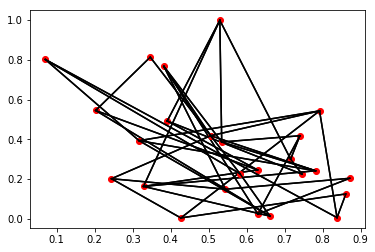

In [2]:
# Define the self-organizing map class

class SOM(object):
    """Represents a self-organizing map with an n-dimensional grid graph of nodes embedded in
    R^n."""
    
    def __init__(self, graph_shape, input_dim, input_min = 0., input_max = 1.):
        """Initialization.
        `graph_shape` is a tuple representing the number of nodes along each dimension.
        `input_dim` is the dimension n of the input space R^n.
        `input_{min,max}` are the expected minimum and maximum values of the input along all 
        dimensions."""
        assert len(graph_shape) >= 1
        assert input_dim >= 1
        self.graph_shape = graph_shape
        self.input_dim = input_dim
        
        # self.locations will be an ndarray, indexed first by graph dimensions and then by 
        # input dimensions.
        # Given graph coordinate tuple, node location is simply locations[graph_tuple]
        self.locations = np.random.uniform(low = input_min, high = input_max,
                                           size = graph_shape + (input_dim,))
    
    def distances(self, point):
        """Return ndarray of shape graph_shape, with entries denoting nodes' distance to
        the point."""
        assert point.shape == (self.input_dim,), (point.shape, self.input_dim)
        coord_deltas = point - self.locations
        distances = (coord_deltas**2).sum(axis = len(self.graph_shape)) ** .5
        assert distances.shape == self.graph_shape
        return distances

    def closest_node(self, point):
        """Return graph coordinates of node closest to the given point."""
        assert point.shape == (self.input_dim,)
        flattened_min_coord = self.distances(point).argmin()
        return np.unravel_index(flattened_min_coord, self.graph_shape)
    
    def draw(self, axes=None):
        """Draw embedding. If graph dimension is more than 2, projects out the first 2.
        Assumes >1 input dimension."""
        assert self.input_dim >= 2
        if axes is None: axes = plt
        for index in np.ndindex(self.graph_shape):
            location = self.locations[index]
            # draw point
            axes.plot([location[0]], [location[1]], 'o', color='r')
            # draw lines to connected points
            for delta in (-1, +1):
                for change_dimension in range(len(self.graph_shape)):
                    new_index = list(index)
                    new_index[change_dimension] += delta
                    if 0 <= new_index[change_dimension] \
                            < self.graph_shape[change_dimension]:
                        new_location = self.locations[tuple(new_index)]
                        axes.plot([location[0], new_location[0]],
                                  [location[1], new_location[1]], '-', color='k')
    
    def graph_distances(self, graph_coord):
        """Returns a vector of shape `self.graph_shape` representing the graph distance
        (Chebyshev distance) from each node of the graph to the given graph coordinate."""
        # Each of these is the list of indices along one graph dimension
        graph_ranges = [np.arange(coord_len) - graph_coord[coord_idx]
                        for (coord_idx, coord_len)
                        in enumerate(self.graph_shape)]
        dim_deltas = np.meshgrid(*graph_ranges)
        dim_distances = np.abs(dim_deltas)
        total_distances = sum(dim_distances)
        return total_distances
    
    def learn_point(self, point, learning_rate, dist_decay = 1):
        """Observe a point, find its winner, and then move node embedding according to
        SOM rules."""
        # Find the winner
        win_idx = self.closest_node(point)
        # Compute nodes' graph distance to the winner
        graph_distances = self.graph_distances(win_idx)
        # Compute location adjustments
        # i.e. locations += exp(-d(l, w)) * learning_rate * (p - l_v)
        point_deltas = point - self.locations
        exp_multipliers = np.exp(-graph_distances * dist_decay)
        exp_multipliers = np.tile(exp_multipliers,
                                  [self.input_dim] + [1] * len(self.graph_shape))
        exp_multipliers = np.swapaxes(exp_multipliers, 0, -1)
        diff = exp_multipliers * learning_rate * point_deltas
        # Adjust node locations
        self.locations += diff
        return win_idx
    
    def normalize_graph_coords(self, graph_idx):
        """Given graph index, divides by graph shape so all coords are in [0, 1]."""
        return np.asarray(graph_idx, dtype=np.float32) / np.asarray(self.graph_shape,
                                                                    dtype=np.float32)


# Test .distances and .closest_node
s = SOM((2, 2), 3, input_min = 0., input_max = 0.) # 2x2 grid graph with all nodes at (0,0,0)
s.locations[0][1][0] = .5
assert (s.distances(np.asarray([1., 0., 0.])) == np.asarray([[1., .5], [1., 1.]])).all()
assert s.closest_node(np.asarray([1., 0., 0.])) == (0, 1)

# Test .graph_distances
s = SOM((10, 8, 11), 3)
assert s.graph_distances([3, 3, 2])[0, 9, 3] == (3 - 0) + (9 - 3) + (3 - 2)

# Try drawing a random SOM
s = SOM((5,5), 2)
s.draw()

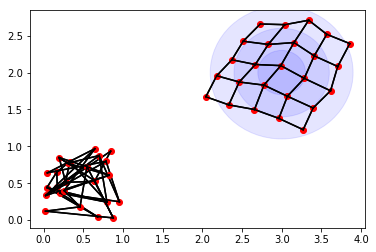

In [3]:
# Now try fitting the SOM to a Gaussian centered some distance away from the SOM.
# First, define dataset and constants:
NUM_POINTS = 200
CENTER = (3., 2.)
s = SOM((5, 5), 2)
point_xs = np.random.normal(loc = CENTER[0], size=(NUM_POINTS,))
point_ys = np.random.normal(loc = CENTER[1], size=(NUM_POINTS,))

# Draw the SOM before any training
s.draw()

# Train the SOM
learning_rates = np.linspace(.3, 0, NUM_POINTS)
for i, point in enumerate(zip(point_xs, point_ys)):
    s.learn_point(np.asarray(point), learning_rate = learning_rates[i], dist_decay = .5)

# Draw the Gaussian
for radius in (.3, .6, .9):
    plt.gca().add_artist(plt.Circle(CENTER, radius, alpha=.1, color='b'))

# Draw the trained SOM, to check that the SOM learned the new distribution
s.draw()

We can see that the SOM has "straightened out" into an embedding that has no overlaps, and has centered itself roughly on top of the Gaussian.

Next, we define a function to general spiral datasets for illustrating and testing how the SOM reduces dimensionality. Later we can also use this to generate classification tasks with classes in interwoven spirals.

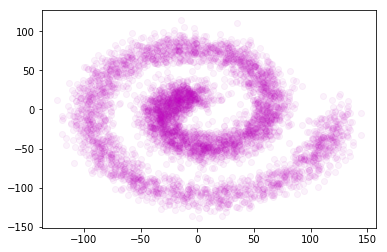

In [4]:
def spiral_points(num_points, min_angle = 0, max_angle = np.pi * 4, start_dist = 0, phase = 0,
                  loop_separation = 3, noise = None):
    """Generate (xs, ys) representing points lying on an Archimidean spiral."""
    # Generate polar coordinates, basically radius = theta.
    thetas = np.random.uniform(low = min_angle, high = max_angle, size = num_points)
    rs = start_dist + loop_separation * thetas
    # convert to Cartesian coordinates
    xs = rs * np.cos(thetas + phase)
    ys = rs * np.sin(thetas + phase)
    if noise is not None:
        xs += np.random.normal(scale = noise, size = num_points)
        ys += np.random.normal(scale = noise, size = num_points)
    return xs, ys

# Test that it's working
np.random.seed(0)
xs, ys = spiral_points(5000, min_angle = np.pi / 2, max_angle = np.pi * 4,
                       loop_separation = 10, noise = 10.)
plt.plot(xs, ys, 'o', color='m', alpha = .05)

Let's try fitting a 1-dimensional SOM to this spiral.

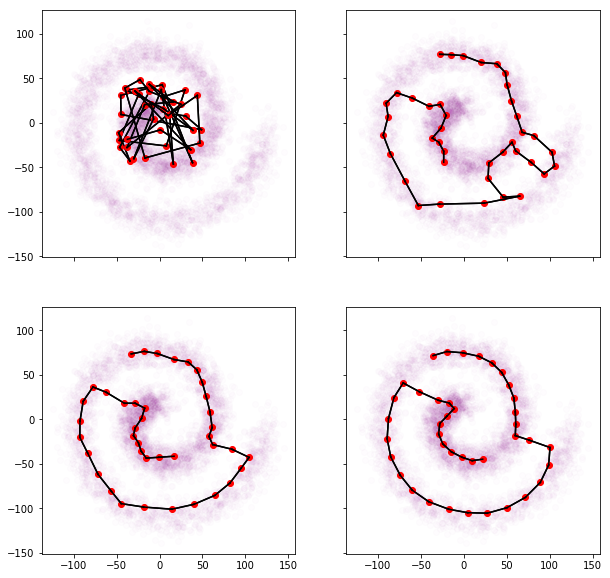

In [5]:
s = SOM((40,), 2, input_min=-50, input_max=50)
num_episodes = 3

# Clear figure and get axes for subplots
plt.clf()
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
axes = [ax1, ax2, ax3, ax4]

for episode in range(num_episodes):
    # Draw intermediate state of SOM
    axes[episode].plot(xs, ys, 'o', color='m', alpha = .01)
    s.draw(axes[episode])
    # Train SOM for one episode
    for (point_idx, point) in enumerate(zip(xs, ys)):
        learning_rate = 1 - (episode * len(xs) + point_idx + 1.) / (len(xs) * num_episodes)
        s.learn_point(np.asarray(point), learning_rate = learning_rate, dist_decay = 1)

# Draw the final SOM
ax4.plot(xs, ys, 'o', color='m', alpha = .01)
plt.gcf().set_size_inches(10, 10)
s.draw()

While the fit is not perfect, it generally mimics the structure. When there are errors, they are usually one of these types:
* "Hernias" where a part of the string stretches out and claims a section of the input that it shouldn't.
* Errors where the end nodes of the SOM are far away from the ends of the spiral, causing some nodes in the middle of the path to "stretch over" to the other side of the spiral.

The noise added to the spiral actually *reduces* both of these types of errors, because it "shakes around" the SOM nodes more which can knock nodes out of local equilibria. In a dataset which *doesn't* have noise, an SOM can benefit by occasionally randomly moving the nodes' locations.

## Differentiable SOM

Now that we have confirmed that the SOM above functions properly, we need to construct the modified version which has a differentiable function from input to output. The desired function is defined by:

$$\text{Output}(p) = \frac{\sum_v ~ g_v ~ \exp\left(-\beta ~ ||p - l_v||_2 \right)}{\sum_v ~ \exp\left(-\beta ~ ||p - l_v||_2 \right)}$$

Here $p$ is the input point, the summands $v$ are the graph vertices, $g_v$ are vertex positions in graph space, and $l_v$ are embedding locations of nodes. Several modifications of this formula are possible, such as squaring the $\ell_2$ distance, or using some other function in place of the exponential. These are possible avenues for further research.

The TensorFlow structure of a resulting NN → SOM → NN system would then be as follows:

<img src="./TF_structure.jpg">

In other words, we feed into TensorFlow both the input and the graph embeddings $l_v$. Backpropagation (dotted lines) can pass backward through the SOM, though this does not affect the SOM's graph embedding; rather, we update the embedding using the ordinary SOM learning mechanism, by picking out the SOM's input point and then using non-TensorFlow code to show that input point to the SOM.

To create the differentiable SOM, we subclass the ordinary SOM, defining a member function which creates the input-output relation as a TensorFlow op.

In [6]:
class DifferentiableSOM(SOM):
    
    def make_tf_op(self, point_op, dist_decay, loc_name, graph):
        """Given a TensorFlow op producing an input point, return a TensorFlow op producing the
        SOM's output, when dist_name is fed with transformed distances to the point."""
        with graph.as_default():
            # Define the embedding location input node. Later we feed this with self.locations.
            location_input = tf.placeholder(shape = self.locations.shape, dtype=tf.float32,
                                            name=loc_name)

            # Compute distances from nodes to input
            coord_deltas = tf.reshape(point_op, (-1,)) - location_input
            distances = tf.reduce_sum(coord_deltas**2, axis=len(self.graph_shape)) ** .5
            
            # Transform the distances
            transformed_distances = tf.exp(-dist_decay * distances)
            transformed_distances /= tf.reduce_sum(transformed_distances) # normalize
            
            # Our output has one real for every graph dimension. We build these separately
            #     and then stack into a vector.
            # The formula for each individual output real is the same as above, except that
            #     g_v represents the position only along one dimension.
            output = []
            graph_positions = self.graph_meshgrid()
            for dim in range(len(self.graph_shape)):
                new_dim = tf.reduce_sum(graph_positions[dim] * transformed_distances)
                    # computes output Σ g_v[i] * (exp(...) / normalizer)
                new_dim /= self.graph_shape[dim] # Normalize by graph dimension, to be in 0..1
                output.append(new_dim)
            output = tf.stack(output) # convert list of singletons into a vector
            return output, location_input
        
    def graph_meshgrid(self):
        """Returns a tuple of len(self.graph_shape) different ndarrays each of shape
        self.graph_shape.
        The return value will have return_value[i][graph_idx] == graph_idx[i]."""
        graph_ranges = [np.arange(coord_len)
                        for (coord_idx, coord_len)
                        in enumerate(self.graph_shape)]
        return np.meshgrid(*graph_ranges)

Next, define a class for easily constructing pipelines involving both NN and SOM layers, while implementing the TensorFlow structure described above. (With additional work this could be made into a Keras layer, but that would probably require rewriting the SOM-update logic into a Keras-compatible form.)

In [7]:
def add_NN_layer(input_op, num_nodes, graph, activation):
    """Construct a neural network layer with the given parameters."""
    with graph.as_default():
        input_vals = int(input_op.shape[1])
        W = tf.Variable(tf.truncated_normal([input_vals, num_nodes], stddev=0.001))
        b = tf.Variable(tf.truncated_normal([num_nodes], stddev=0.001))
        preac = tf.matmul(input_op, W) + b
        postac = activation(preac)
        return postac

class ClassificationPipeline(object):
    """Represents standard pipeline involving SOMs and NNs, used for n-way classification."""
    
    def __init__(self, spec, num_classes, num_inputs, input_dtype=tf.float32):
        """Construct inputs, NN/SOM layers, output, and training op.
        `spec` is specification in the form of a list of dicts, including:
            - Layer type ("NN" or "SOM").
            - If an SOM: graph_shape and predict_dist_decay to use for Output(p) function.
            - If an NN: num_nodes and activation."""
        self.spec = spec
        self.num_inputs = num_inputs
        self.num_classes = num_classes
        
        # Use dicts to maintain mappings from layer index to SOM-related objects, if that index
        #     is an SOM.
        self.SOMs = {}
        self.SOM_inputs = {}
        self.SOM_loc_inputs = {}
        self.SOM_layer_indices = [] # in sorted order
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.input = tf.placeholder(input_dtype, [None, num_inputs])
            self.labels_onehot = tf.placeholder(tf.float32, shape=[None, num_classes])
            
            end_op = self.input # Stores op at the end that we're building on
            for layer_idx, layer in enumerate(spec):
                if layer["type"] == "NN":
                    end_op = add_NN_layer(end_op, layer["num_nodes"], self.graph,
                                          layer["activation"])
                elif layer["type"] == "SOM":
                    som = DifferentiableSOM(layer["graph_shape"],
                                            input_dim = int(end_op.shape[1]))
                    som_out, som_loc_input = som.make_tf_op(end_op,
                                                dist_decay = layer["predict_dist_decay"],
                                                loc_name = "%d-som-loc-input" % layer_idx,
                                                graph = self.graph)
                    self.SOM_layer_indices.append(layer_idx)
                    self.SOM_inputs[layer_idx] = end_op
                    self.SOMs[layer_idx] = som
                    self.SOM_loc_inputs[layer_idx] = som_loc_input
                    end_op = tf.reshape(som_out, (1, -1))
                else:
                    raise Exception("Invalid layer type %s" % layer["type"])
                assert len(end_op.shape) == 2
            
            self.probability_output = end_op
            
            # Define evaluation functions
            self.correct_prediction = tf.equal(tf.argmax(self.probability_output, 1),
                                               tf.argmax(self.labels_onehot, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
            
            # Define loss and training op; same functions are used for all examples.
            cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                    labels = self.labels_onehot,
                    logits = self.probability_output))
            self.train_step = tf.train.GradientDescentOptimizer(1.).minimize(cross_entropy)
        
    def som_loc_feeds(self):
        """Construct dict from SOM feed ops to those SOMs' locations, to feed into
        TensorFlow."""
        result = {}
        for idx, SOM in self.SOMs.items():
            result[self.SOM_loc_inputs[idx]] = SOM.locations
        return result

    def test(self, test_points, test_cats_onehot, sess):
        """Test the pipeline, returning accuracy."""
        # We could test them all in one batch in a pure NN network, but the SOM operation as
        #    defined above takes a single input, so we must iterate through the points.
        correct = 0
        for point, cat1h in zip(test_points, test_cats_onehot):
            # Construct feed_dict
            feed_dict = self.som_loc_feeds()
            feed_dict[self.input] = point.reshape(1, self.num_inputs)
            feed_dict[self.labels_onehot] = cat1h.reshape(1, self.num_classes)

            # Run pipeline to find probability outputs, and determine whether argmax prediction
            #     was correct.
            probabilities = sess.run(self.probability_output, feed_dict = feed_dict
                                     #     
            prediction = np.argmax(probabilities)
            if prediction == np.argmax(cat1h):
                correct += 1
        return correct / len(test_points)

    def train_single(self, train_point, train_cats_onehot, sess, som_learning_rate=None,
                     som_learn_dist_decay=None):
        """Train the pipeline, both through backprop and with SOM mechanism, on a single
        example."""
        # Construct feed dict
        feed_dict = self.som_loc_feeds()
        feed_dict[self.input] = train_point.reshape(1, self.num_inputs)
        feed_dict[self.labels_onehot] = train_cats_onehot.reshape(1, self.num_classes)

        # Run training step and collect SOM input points
        output_ops = [self.train_step] + [self.SOM_inputs[index]
                                          for index in self.SOM_layer_indices]
                # values we need from TF
        outputs = sess.run(output_ops, feed_dict = feed_dict)

        # Train the SOMs on their input points
        curr_output_idx = 1
        for layer_idx in self.SOM_layer_indices:
            self.SOMs[layer_idx].learn_point(outputs[curr_output_idx].reshape(-1),
                                             learning_rate = som_learning_rate,
                                             dist_decay = som_learn_dist_decay)
            curr_output_idx += 1
            
    def train_and_test(self, num_episodes, train_points, train_cats1h, test_points,
                       test_cats1h, test_freq = 500, test_per_report = 10,
                       som_learning_rate = 1., som_learn_dist_decay = 1.,
                       som_learn_rate_decay = 1.):
        """Train the pipeline and periodically test it. Returns (list of step numbers, list
            of accuracy at that step)."""
        with tf.Session(graph = self.graph) as sess:
            tf.global_variables_initializer().run()
            step_list, acc_list = [], []
            num_steps = 0
            num_points = len(train_points)
            total_steps = num_points * num_episodes
            for episode in range(num_episodes):
                for _ in range(num_points):
                    idx = random.randint(0, num_points - 1)
                    point = train_points[idx]
                    cat = train_cats1h[idx]
                    learning_rate = som_learning_rate * \
                                     ((total_steps - num_steps) / total_steps) ** \
                                         som_learn_rate_decay
                    self.train_single(point, cat, sess, som_learning_rate,
                                      som_learn_dist_decay)
                    num_steps += 1
                    if not (num_steps % test_freq) or num_steps == 1:
                        test_acc = self.test(test_points, test_cats1h, sess
                                             
                        step_list.append(num_steps)
                        acc_list.append(test_acc)
                        if not ((num_steps / test_freq) % test_per_report) or num_steps == 1:
                            frac_done = num_steps / total_steps
                            print("Step number %d (%d%% done), test-set accuracy is %f" % \
                                  (num_steps, 100 * frac_done, test_acc))
            return step_list, acc_list



### Spiral classification problem

Next I'll build a classification problem where the points to be classified lie on a spiral in the plane, and where proper classification will require the model to understand and unravel this spiral structure.

I'll evaluate the performance of a 2-layer NN on this problem, and compare it to the performance of an SOM+NN model of similar complexity.

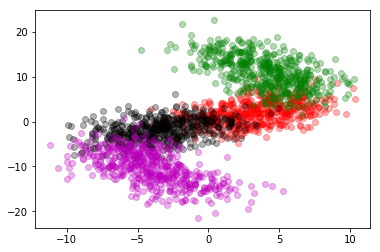

In [8]:
def spiral_classification(num_cats, points_per_cat, max_angle, plot = False,
                          colors = 'rgb', *args, **kwargs):
    """Create spiral classification problem. Returns list of (x,y) points, and list of
    categories."""
    point_groups = [] # list of arrays each of shape (points_per_cat, 2), representing
                      #    points of each class
    cat_groups = [] # list of arrays each of shape (points_per_cat,), representing category
                    #     of corresponding point
    angle_per_cat = max_angle / num_cats
    for cat in range(num_cats):
        xs, ys = spiral_points(points_per_cat, min_angle = angle_per_cat * cat,
                               max_angle = angle_per_cat * (cat + 1), *args, **kwargs)
        points = np.stack((xs, ys), axis=1)
        cats = np.repeat(cat, points_per_cat)
        point_groups.append(points)
        cat_groups.append(cats)
        if plot:
            plt.plot(xs, ys, 'o', color = colors[cat], alpha = .3)
    all_points = np.concatenate(point_groups)
    all_cats = np.concatenate(cat_groups)
    return all_points, all_cats

def double_spiral_classification(num_cats, points_per_cat, colors1, colors2,
                                 max_angle = np.pi, **kwargs):
    """Creates a spiral classification problem with two spiral arms."""
    points1, cats1 = spiral_classification(int(num_cats/2), points_per_cat, max_angle,
                                           colors = colors1, **kwargs)
    points2, cats2 = spiral_classification(int(num_cats/2), points_per_cat, max_angle,
                                           colors = colors2, phase = np.pi, **kwargs)
    cats2 += int(num_cats / 2)
    points = np.concatenate((points1, points2))
    cats = np.concatenate((cats1, cats2))
    return points, cats

# Create the actual dataset, and plot it.
num_classes = 4
points, cats = double_spiral_classification(4, 500, 'rg', 'km', plot=True, noise = 2,
                                            loop_separation = 10, max_angle = np.pi / 2)
cats_onehot = np.eye(num_classes)[cats]

# Shuffle the data, create train and test sets
def shuffle_together(xs, ys):
    permutation = np.random.permutation(len(xs))
    return xs[permutation], ys[permutation]
points_shuffled, cats1h_shuffled = shuffle_together(points, cats_onehot)
train_size = int(len(points) * .9)
test_size = len(points) - train_size
train_points = points_shuffled[:train_size]
train_cats1h = cats1h_shuffled[:train_size]
test_points = points_shuffled[train_size:]
test_cats1h = cats1h_shuffled[train_size:]

Step number 1 (0% done), test-set accuracy is 0.210000
Step number 5000 (18% done), test-set accuracy is 0.385000
Step number 10000 (37% done), test-set accuracy is 0.410000
Step number 15000 (55% done), test-set accuracy is 0.385000
Step number 20000 (74% done), test-set accuracy is 0.415000
Step number 25000 (92% done), test-set accuracy is 0.400000


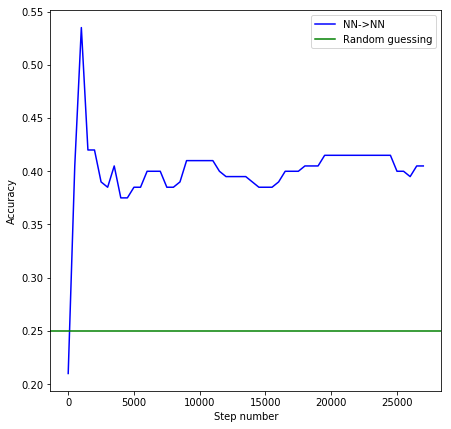

In [9]:
# Build a simple NN pipeline with 1 hidden layer (2 weight matrices), and evaluate
#     its performance.
pipeline = ClassificationPipeline(spec = [
            {"type": "NN", "num_nodes": 10, "activation": tf.nn.relu},
            {"type": "NN", "num_nodes": 4,  "activation": tf.nn.softmax}],
    num_classes = 4, num_inputs = 2)

nn_step_list, nn_acc_list = pipeline.train_and_test(15, train_points, train_cats1h,
                                                    test_points, test_cats1h)

plt.plot(nn_step_list, nn_acc_list, '-', color='b', label='NN->NN')
plt.axhline(.25, label = 'Random guessing', color = 'g')
plt.xlabel("Step number")
plt.ylabel("Accuracy")
plt.legend()
plt.gcf().set_size_inches(7, 7)

The NN achieves performance above the random guessing baseline.

Next, we construct a model which preprocesses the data using an SOM. Input points are sent to an SOM layer, then through an NN layer for 4-way softmax classification.

Step number 1 (0% done), test-set accuracy is 0.210000
Step number 5000 (18% done), test-set accuracy is 0.835000
Step number 10000 (37% done), test-set accuracy is 0.840000
Step number 15000 (55% done), test-set accuracy is 0.810000
Step number 20000 (74% done), test-set accuracy is 0.855000
Step number 25000 (92% done), test-set accuracy is 0.840000


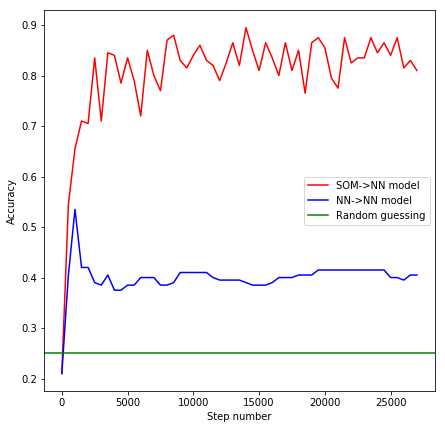

In [10]:
pipeline = ClassificationPipeline(spec = [{"type": "SOM", "graph_shape": (20,),
                                               "predict_dist_decay": 1},
                                          {"type": "NN", "num_nodes": 4,
                                           "activation": tf.nn.softmax}],
    num_classes = 4, num_inputs = 2)

sn_step_list, sn_acc_list = pipeline.train_and_test(15, train_points, train_cats1h,
                                                    test_points, test_cats1h,
                                                    som_learning_rate = 1,
                                                    som_learn_dist_decay = 1)


plt.plot(sn_step_list, sn_acc_list, '-', label = 'SOM->NN model', color = 'r')
plt.plot(nn_step_list, nn_acc_list, '-', label = 'NN->NN model', color = 'b')
plt.axhline(.25, label = 'Random guessing', color = 'g')
plt.legend()
plt.xlabel("Step number")
plt.ylabel("Accuracy")
plt.gcf().set_size_inches(7, 7)

The SOM → NN model did much better than the NN → NN model, boosting accuracy from ~50% to ~85% (in this run).

We can check the SOM's fit as follows:

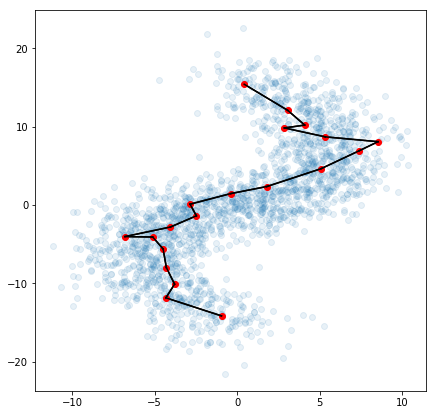

In [11]:
# Try drawing the SOM and the dataset, to see SOM's fit
plt.plot(points[:, 0], points[:, 1], 'o', alpha=.1)
pipeline.SOMs[0].draw()
plt.gcf().set_size_inches(7, 7)

The SOM has approximately fit to the spiral shape.

Next I'll try building a NN → SOM → NN model, i.e. inputs will feed into a 3-node neural net, which will feed into a 5x5 SOM, which will feed into a final 4-node softmax NN classification layer.

Step number 1 (0% done), test-set accuracy is 0.330000
Step number 5000 (18% done), test-set accuracy is 0.540000
Step number 10000 (37% done), test-set accuracy is 0.600000
Step number 15000 (55% done), test-set accuracy is 0.515000
Step number 20000 (74% done), test-set accuracy is 0.490000
Step number 25000 (92% done), test-set accuracy is 0.680000


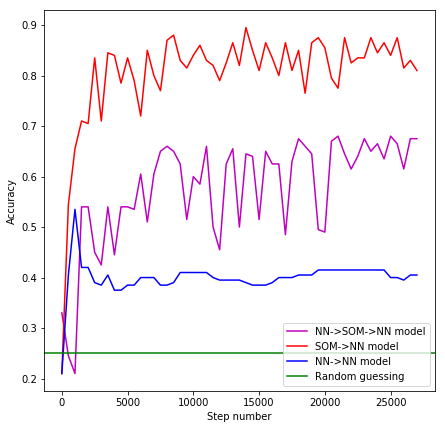

In [12]:
pipeline = ClassificationPipeline(spec = [{"type": "NN", "num_nodes": 3,
                                               "activation": tf.nn.softmax},
                                          {"type": "SOM", "graph_shape": (5,5),
                                               "predict_dist_decay": 1},
                                          {"type": "NN", "num_nodes": 4,
                                               "activation": tf.nn.softmax}],
    num_classes = 4, num_inputs = 2)

nsn_step_list, nsn_acc_list = pipeline.train_and_test(15, train_points, train_cats1h,
                                                      test_points, test_cats1h,
                                                      som_learn_dist_decay = 1.,
                                                      som_learn_rate_decay = 0.5,
                                                      som_learning_rate=.1)


plt.plot(nsn_step_list, nsn_acc_list, '-', label = 'NN->SOM->NN model', color = 'm')
plt.plot(sn_step_list, sn_acc_list, '-', label = 'SOM->NN model', color = 'r')
plt.plot(nn_step_list, nn_acc_list, '-', label = 'NN->NN model', color = 'b')
plt.axhline(.25, label = 'Random guessing', color = 'g')
plt.legend()
plt.xlabel("Step number")
plt.ylabel("Accuracy")
plt.gcf().set_size_inches(7, 7)

The NN→SOM→NN model outperformed the NN→NN model, but not the SOM→NN model.

It may be helpful to try to visualize the middle SOM's 3-dimensional shape.

The following JavaScript applets won't render on GitHub, though they will render if you pull the repo and open this file in Jupyter, if you have the dependencies (TensorFlow, etc.) installed.


<IPython.core.display.Javascript object>


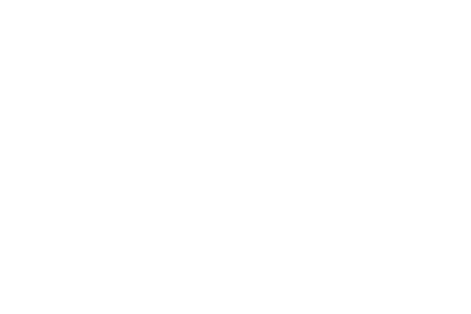

<IPython.core.display.Javascript object>


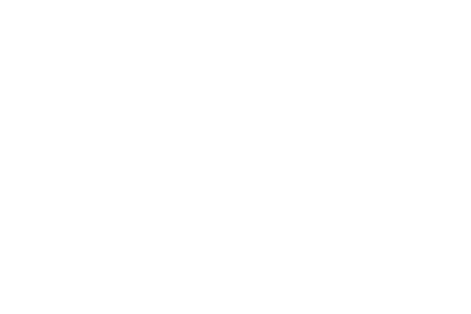

In [13]:
%matplotlib notebook
som = pipeline.SOMs[1]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for index in np.ndindex(som.graph_shape):
    location = som.locations[index]
    # draw point
    ax.plot([location[0]], [location[1]], [location[2]], 'o', color='r')
    # draw lines to connected points
    for delta in (-1, +1):
        for change_dimension in range(len(som.graph_shape)):
            new_index = list(index)
            new_index[change_dimension] += delta
            if 0 <= new_index[change_dimension] < som.graph_shape[change_dimension]:
                new_location = som.locations[tuple(new_index)]
                ax.plot([location[0], new_location[0]], [location[1], new_location[1]],
                        [location[2], new_location[2]],
                          '-', color='k')

The SOM seems to be fitting to some sort of 2-dimensional manifold in 3-dimensional space. If the interactive visualization doesn't work, you can remove the "%matplotlib notebook" line at the top of the cell to see a static image instead.

## Challenges and possible solutions

These tests suggests that preprocessing with SOMs can be useful for some datasets, and backpropagation through SOMs can also achieve better results than comparable NNs on this dataset. This is despite a similar learning methodology, namely 15 episodes of gradient descent on the same dataset.

Outside of this sample dataset, SOM preprocessing (but not backpropagation through SOMs) has been demonstrated to have practical use; see for instance: Mark O. Afolabi and Olatoyosi Olude (2007), [*Predicting Stock Prices Using a Hybrid Kohonen Self Organizing Map (SOM)*](http://ieeexplore.ieee.org/xpl/freeabs_all.jsp?arnumber=4076468), in 40th Annual Hawaii International Conference On System Sciences, 2007, IEEE, pp. 48–56.

SOMs are not suitable for widespread insertion into current state-of-the-art neural networks, due to several challenges:

1. The curse of dimensionality is especially detrimental to SOMs compared to NNs. The number of parameters of an NN layer is roughly linear in the number of output dimensions (i.e. the number of nodes), since doubling the number of nodes doubles the number of entries in the weight matrices interfacing with the adjacent layers. In contrast, an SOM with $d$ output dimensions and a given side-length $s$ to its graph must have $s^d$ nodes, and must thus store and work with $s^d$ locations, each of which has length equal to the number of input dimensions. In the tests above this was not a major problem because all tests used low-dimensional datasets. For high-dimensional datasets, there are ways to possibly address this problem:
    * We can try to reduce the dimensionality of the input and output spaces. For instance, we can train an autoencoder built from NN layers, then feed its compact representation into an SOM layer which can feed into the rest of the model. Nevertheless, some problems are probably inherently high-dimensional in the sense that inputs and outputs cannot be transformed to a low-dimensional space without losing important information.
    * There are alternatives to self-organizing maps which do not use discrete graphs but rather learn continuous mappings, such as [generative topographical maps](https://en.wikipedia.org/wiki/Generative_topographic_map). These may allow us to effectively reduce the side-length $s$.

2. There has been a lot of work in optimizing neural networks and their training, such as the invention of better alternatives to gradient descent (such as the Adam optimizer), better regularization methods (such as dropout), better network structures (such as recurrent or convolutional neural networks), and other improvements (such as batch normalization). These improvements each give significant performance boosts, producing a [lock-in effect](https://en.wikipedia.org/wiki/Vendor_lock-in) - even if SOMs could perform comparably to NNs after a similar amount of research were done (which is doubtful), such research will not yield benefits until a substantial amount is done, so there is little short-term incentive to do any. For this reason the examples above were done without any form of regularization and with plain stochastic gradient descent.

3. Neural networks face problems with "internal covariate shift" - each layer's learned input-output transformation is gradually invalidated because the learning process modifies the values produced by the earlier layers, so that the "correct" input-output transformation at a given layer is a constantly moving target. [This was actually one of the major motivations for the invention of batch normalization.](https://arxiv.org/abs/1502.03167). SOMs can exacerbate this problem because their learning mechanism is decoupled from the rest of the network, and a poor choice of SOM hyperparameters can result in large graph shifts that render worthless some of the learning previously done by NN layers.

4. Choosing SOM hyperparameters is fairly difficult for nontrivial examples. SOMs have many hyperparameters, such as the shape of the graph, the shape of the learning curve, and the shape of the decay curve for the differentiable input-output function defined here. Choosing any of these poorly can greatly degrade performance. In the final NN→SOM→NN model, I had to try about 10 values of the hyperparameters on a validation set first, and this is still a simple low-dimensional dataset. There are some ways to address this problem:
    * One could devise SOMs that adaptively choose their hyperparameters. For instance, we could use a method similar to RMSprop to adaptively modify the learning rate depending on the size of recent changes in the embedding. Or we could imagine changing the number of nodes per side by "upsampling" or "downsampling" them, i.e. filling in or removing intermediate nodes, depending on some metric such as the curvature of node edges. For instance in the spiral example we could add nodes around the bends in the spiral where the line bends sharply.
    * To choose the dimensionaly of the graph it is helpful to know the dimension of the low-dimensional manifold. This can be done by visualization (as in the examples above). An alternative is to use automatic methods of finding low-dimensional manifolds and inferring their dimensionality. See for instance: Xiaohui Wang, J. S. Marron. [*A scale-based approach to finding effective dimensionality in manifold learning*](https://arxiv.org/abs/0710.5349), on ArXiv, updated 2008.


## Further research

There are several directions for possible further research, including:

1. Classification problems sometimes involve multiple classes that are entangled in links, such as interlocking rings (or arrangements topologically equivalent to that); see [here](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) for an exposition. Neural networks generally perform fairly well on these by "stretching" the rings apart, but since their transformations are continuous they leave some points in the entangled region. We could try fitting two different SOMs to the two different classes, which will probably perform well on simple tasks. But it is unclear how to productively integrate such a classification system with a neural network, so I did not try this in my project.

2. We could investigate variations of the standard SOM design. For instance:
    * We could remove the edges of the SOM graph, using as its output a vector of distances to each SOM node. This essentially produces a radial basis network with moving centroids.
    * We could experiment with SOM models where the graph adaptively grows additional nodes. This would interfere with the "graph space output" methodology above, but could be workable with the disconnected SOM proposed above.
    * We could add momentum, acceleration, swarm dynamics, or other modifications to the dynamics of the nodes.

Thanks for reading! :)